<a href="https://colab.research.google.com/github/jtghchau/TextClassification/blob/main/Probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

modelName1 = "distilbert-base-uncased-finetuned-sst-2-english"
model1 = AutoModelForSequenceClassification.from_pretrained(modelName1, output_hidden_states=True)
tokenizer1 = AutoTokenizer.from_pretrained(modelName1)
model1.eval()

modelName2 = "textattack/bert-base-uncased-SST-2"
model2 = AutoModelForSequenceClassification.from_pretrained(modelName2, output_hidden_states=True)
tokenizer2 = AutoTokenizer.from_pretrained(modelName2)
model2.eval()

dataset = load_dataset("imdb")
train_samples = dataset["train"].shuffle(seed=42).select(range(300))
test_samples = dataset["test"].shuffle(seed=42).select(range(300))

In [2]:
def extractHiddenStates(text, model, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
  with torch.no_grad():
      outputs = model(**inputs)
  return outputs.hidden_states

hiddenStatesPerLayer1_train = [[] for _ in range(model1.config.num_hidden_layers + 1)]
hiddenStatesPerLayer1_test = [[] for _ in range(model1.config.num_hidden_layers + 1)]
labels1_train, labels1_test = [], []

hiddenStatesPerLayer2_train = [[] for _ in range(model2.config.num_hidden_layers + 1)]
hiddenStatesPerLayer2_test = [[] for _ in range(model2.config.num_hidden_layers + 1)]
labels2_train, labels2_test = [], []

def process_samples(samples, model, tokenizer, hiddenStatesPerLayer, labels):
    for example in samples:
        text, label = example["text"], example["label"]
        hiddenStates = extractHiddenStates(text, model, tokenizer)
        clsEmbeddings = [layer[0, 0, :].numpy() for layer in hiddenStates]

        for i, emb in enumerate(clsEmbeddings):
            hiddenStatesPerLayer[i].append(emb)
        labels.append(label)

process_samples(train_samples, model1, tokenizer1, hiddenStatesPerLayer1_train, labels1_train)
process_samples(test_samples, model1, tokenizer1, hiddenStatesPerLayer1_test, labels1_test)
process_samples(train_samples, model2, tokenizer2, hiddenStatesPerLayer2_train, labels2_train)
process_samples(test_samples, model2, tokenizer2, hiddenStatesPerLayer2_test, labels2_test)

labels1_train = torch.tensor(labels1_train, dtype=torch.float32)
labels1_test = torch.tensor(labels1_test, dtype=torch.float32)
labels2_train = torch.tensor(labels2_train, dtype=torch.float32)
labels2_test = torch.tensor(labels2_test, dtype=torch.float32)

Layer 0: Accuracy = 0.5000 (distilBERT)
Layer 1: Accuracy = 0.6633 (distilBERT)
Layer 2: Accuracy = 0.6933 (distilBERT)
Layer 3: Accuracy = 0.7233 (distilBERT)
Layer 4: Accuracy = 0.7333 (distilBERT)
Layer 5: Accuracy = 0.8400 (distilBERT)
Layer 6: Accuracy = 0.8700 (distilBERT)


Layer 0: Accuracy = 0.5000 (BERT)
Layer 1: Accuracy = 0.5867 (BERT)
Layer 2: Accuracy = 0.6500 (BERT)
Layer 3: Accuracy = 0.6667 (BERT)
Layer 4: Accuracy = 0.7067 (BERT)
Layer 5: Accuracy = 0.6933 (BERT)
Layer 6: Accuracy = 0.7233 (BERT)




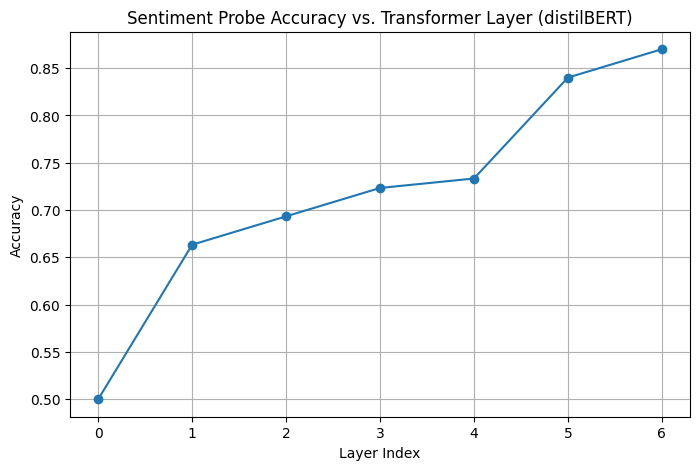

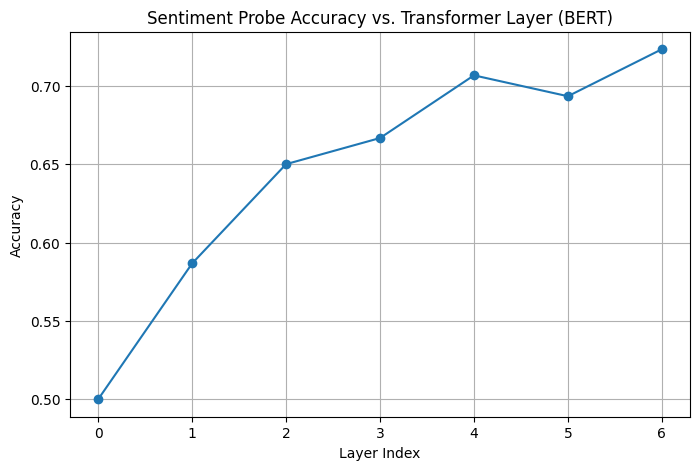

In [6]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze(-1)

def trainAndEvaluate(X_train, y_train, X_test, y_test):
    X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
    y_train = y_train
    X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
    y_test = y_test

    modelProbe = LogisticRegression(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(modelProbe.parameters(), lr=0.01)

    for epoch in range(100):
        optimizer.zero_grad()
        outputs = modelProbe(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        preds = (torch.sigmoid(modelProbe(X_test)) > 0.5).float()
        accuracy = (preds == y_test).float().mean().item()

    return accuracy

layerAccuracies1 = {}
layerAccuracies2 = {}

for layerIdx in range(len(hiddenStatesPerLayer1_train)):
    layerAccuracies1[layerIdx] = trainAndEvaluate(hiddenStatesPerLayer1_train[layerIdx], labels1_train, hiddenStatesPerLayer1_test[layerIdx], labels1_test)
    layerAccuracies2[layerIdx] = trainAndEvaluate(hiddenStatesPerLayer2_train[layerIdx], labels2_train, hiddenStatesPerLayer2_test[layerIdx], labels2_test)

for layer, acc in sorted(layerAccuracies1.items()):
    print(f"Layer {layer}: Accuracy = {acc:.4f} (distilBERT)")

print("\n")

for layer, acc in sorted(layerAccuracies2.items()):
    print(f"Layer {layer}: Accuracy = {acc:.4f} (BERT)")

print("\n")

import matplotlib.pyplot as plt

layers1 = list(layerAccuracies1.keys())
accuracies1 = list(layerAccuracies1.values())

plt.figure(figsize=(8, 5))
plt.plot(layers1, accuracies1, marker='o', linestyle='-')
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.title("Sentiment Probe Accuracy vs. Transformer Layer (distilBERT)")
plt.grid(True)
plt.show()

print("\n")

layers2 = list(layerAccuracies2.keys())
accuracies2 = list(layerAccuracies2.values())

plt.figure(figsize=(8, 5))
plt.plot(layers2, accuracies2, marker='o', linestyle='-')
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.title("Sentiment Probe Accuracy vs. Transformer Layer (BERT)")
plt.grid(True)
plt.show()


---
#**Discussion**:


If I saw strong attention to sentiment words in the 8th layer, I do see a higher accuracy for that layer's embeddings but it is still possible for a higher accuracy to be acheived later on in the later transformer layers.

Surprises:

I was suprised on how the accuracy scaled. I rememeber from our meeting on monday there should be a base line accuracy in which the model should output and if not there is something wrong with its implementation. So I thought it would be a lower accuracy and slowly scale up to a higher accuracy. Based on my data, the starting/minimun accuracy for both models were 50% and jumped up right to around 70% which was a huge jump in my opinion. The peak layer ended up being the second to last layer in both models with the accuracies being 0.99 in both models. But the in the last layer of each model distilBERT has a higher percentage in change compared to BERT. DistilBERT went from 0.9900 to 0.9667 while BERT went from 0.9900 to 0.9867

Update*: I have now implemented the different datasets (Train and Test) and now have what now should be more accurate results. My accuracy did go down after implemented the samples but I believe that is due to a lower amount of samples for the training dataset. If I were to increase it which I might do later the accuracy should go up when it is tested on the test samples.

---



